# Summary

If you feel 16GB memory is too small for >200 features bond-wise, you are not alone. In this kernel, we updated Andrew's workflow by generating features for each type to save memory. No `reduce_mem_usage` by Andrew is used (except when importing QM9), so every computation is retained its `np.float64` default accuracy. 

Within the loop of the training for each type, first the features are generated for a minimal passed train/test dataframe, then [Giba's features](https://www.kaggle.com/scaomath/lgb-giba-features-qm9-custom-objective-in-python) are loaded using the format of a kernel I made earlier. Finally the [Yukawa potentials](https://www.kaggle.com/scaomath/parallelization-of-coulomb-yukawa-interaction) are added as well using `structures` dataframe by type to save a tons of memory.

Just wrapping your feature generation into a function you are good to go.


### References:
- [Brute force feature engineering](https://www.kaggle.com/artgor/brute-force-feature-engineering)
- [Keras Neural Net for CHAMPS](https://www.kaggle.com/todnewman/keras-neural-net-for-champs)
- [Giba R + data.table + Simple Features](https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb)

# Libraries and functions

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Andrew's utils
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # 初期状態のメモリ消費量確認 （=value.nbytes)
    start_mem = df.memory_usage().sum() / 1024**2    
    
    # 各列について
    for col in df.columns:
        col_type = df[col].dtypes
        # 列のタイプがint16~64 or float16~64なら
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            # int型なら
            if str(col_type)[:3] == 'int':
                # 列の全値がint8型の範囲に収まるなら列の値をint8型に変換
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 列の全値がint16型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 列の全値がint32型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 列の全値がint64型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float型なら
            else:
                # 列の全値がfloat32型の範囲に収まるなら列の値をfloat32型に変換
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 列の値をfloat64型に
                else:
                    df[col] = df[col].astype(np.float64)
    # 型変換の後のメモリ消費量を確認
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 評価指標
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb',
                           eval_metric='mae', columns=None, plot_feature_importance=False,
                           model=None, verbose=10000, early_stopping_rounds=200,
                           n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train（test?) data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        # 各Foldについて
        # k-fold目の開始時間
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else: # pd.DataFrameの場合
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        # LightGBM
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        # XGBoost
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        # sklearnのモデル
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        # CatBoost
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        # 現在のFoldにおけるvalidデータの予測値
        oof[valid_index] = y_pred_valid.reshape(-1,)
        # validデータに関するscore
        if eval_metric != 'group_mae': # sklearnのscore関数を用いる
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        # testデータの予測値に足し合わせる×foldの数
        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            # 各foldについてfeature importance算出
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            # 縦に連結
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        # for文ここまで----
        
    # foldの数だけ足し合わせた予測値をfoldの数で割る→cv score
    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    # 各foldでvalidになっている部分の予測値を埋めたので、全てのデータのoofでの予測値が入る
    result_dict['oof'] = oof
    # testデータの予測値
    result_dict['prediction'] = prediction
    # validデータのscore
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            # 各特徴量について、feature importanceがfold数の分あるので、fold数で割る
            feature_importance["importance"] /= folds.n_splits
            # feature_importanceのDataFrameの"feature", "importance"列について操作
            # "feature"ごとの"importance"の平均値を取得、
            # 降順にソートした上位50個の特徴量をcolとする
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            # 上位50個の特徴量についての行を抽出、best_featuresとする
            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            # plotの描画
            plt.figure(figsize=(16, 12));
            # best_featuresについて降順にソートしてプロット
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

## Data loading and overview

In [4]:
file_folder = 'champs-scalar-coupling' 
# '../input/champs-scalar-coupling'  (kaggle)
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [5]:
path = 'parallelization-of-coulomb-yukawa-interaction'
structures_yukawa = pd.read_csv(f'{path}/structures_yukawa.csv')
structures = pd.concat([structures, structures_yukawa], axis=1)
del structures_yukawa

In [6]:
y = train['scalar_coupling_constant']
train = train.drop(columns = ['scalar_coupling_constant'])

# Feature generation funcs

The features here are:

- First the `type` is encoded by a label encoder.
- The merging template and selected features from [Andrew's brute force feature engineering](https://www.kaggle.com/artgor/brute-force-feature-engineering)
- Cosine features originally from [Effective feature](https://www.kaggle.com/kmat2019/effective-feature) and expanded in [Keras Neural Net for CHAMPS](https://www.kaggle.com/todnewman/keras-neural-net-for-champs), I simplified the generation procedure by removing unnecessary `pandas` operations since vanilla `numpy` arrays operation is faster.
- QM9 dataset from [Quantum Machine 9 - QM9](https://www.kaggle.com/zaharch/quantum-machine-9-qm9).
- Parallelization computed [Yukawa potentials](https://www.kaggle.com/scaomath/parallelization-of-coulomb-yukawa-interaction).
- Giba's features from [Giba R + data.table + Simple Features](https://www.kaggle.com/titericz/giba-r-data-table-simple-features-1-17-lb), which I now export the features to a dataset: [Giba molecular features](https://www.kaggle.com/scaomath/giba-molecular-features).

In [7]:
# DataFrameの結合
def map_atom_info(df_1, df_2, atom_idx):
    # df_1とdf_2の'molecule_name'、df_1の'atom_index_i'とdf_2の'atom_index'が
    # 共通している列をキーとして結合
    # df_1のサンプルは全て残す（df_2の列を持たない部分はNanに）
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    # 'atom_index'の列の値が重複するので削除
    df = df.drop('atom_index', axis=1)
    return df

# 距離計算
def find_dist(df):
    # 注目する2原子について
    # 1つ目の原子の座標
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    # 2つ目の原子の座標
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    # 距離
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    # 1/(距離)^2
    df['dist_inv2'] = 1/df['dist']**2
    # x, y, z方向の距離
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    return df

# 
def find_closest_atom(df):    
    df_temp = df.loc[:,["molecule_name",
                      "atom_index_0","atom_index_1",
                      "dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_ = df_temp.copy()
    # 2原子の順番を逆にして一列で全ての原子を網羅
    df_temp_ = df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp_all = pd.concat((df_temp,df_temp_),axis=0)

    # 各分子の一原子について、最も近い原子との距離(min)、最も遠い原子との距離(max)を求める
    df_temp_all["min_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('min')
    df_temp_all["max_distance"]=df_temp_all.groupby(['molecule_name', 
                                                     'atom_index_0'])['dist'].transform('max')
    
    # 各分子で原子間距離が最小の原子のみを取り出す
    df_temp = df_temp_all[df_temp_all["min_distance"]==df_temp_all["dist"]].copy()
    # 重複を削る
    df_temp = df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp = df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_closest',
                                         'dist': 'distance_closest',
                                         'x_1': 'x_closest',
                                         'y_1': 'y_closest',
                                         'z_1': 'z_closest'})
    # 分子名と注目原子が重複しているものは削除
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
    
    for atom_idx in [0,1]:
        # 各原子について、最近傍の原子のindex, 距離、座標の情報を追加
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    
    # 各分子で原子間距離が最大の原子のみを取り出す
    df_temp= df_temp_all[df_temp_all["max_distance"]==df_temp_all["dist"]].copy()
    df_temp = df_temp.drop(['x_0','y_0','z_0','max_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                         'atom_index_1': 'atom_index_farthest',
                                         'dist': 'distance_farthest',
                                         'x_1': 'x_farthest',
                                         'y_1': 'y_farthest',
                                         'z_1': 'z_farthest'})
    # 分子名と注目原子が重複しているものは削除
    df_temp = df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])
        
    for atom_idx in [0,1]:
        # 各原子について、分子内で最も遠い原子のindex, 距離、座標の情報を追加
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_farthest': f'atom_index_farthest_{atom_idx}',
                                        'distance_farthest': f'distance_farthest_{atom_idx}',
                                        'x_farthest': f'x_farthest_{atom_idx}',
                                        'y_farthest': f'y_farthest_{atom_idx}',
                                        'z_farthest': f'z_farthest_{atom_idx}'})
    return df


def add_cos_features(df):
    
    # 1原子目と分子の重心との距離
    df["distance_center0"] = np.sqrt((df['x_0']-df['c_x'])**2 \
                                   + (df['y_0']-df['c_y'])**2 \
                                   + (df['z_0']-df['c_z'])**2)
    # 2原子目と分子の重心との距離
    df["distance_center1"] = np.sqrt((df['x_1']-df['c_x'])**2 \
                                   + (df['y_1']-df['c_y'])**2 \
                                   + (df['z_1']-df['c_z'])**2)
    # 1原子目の最近傍原子との距離
    df['distance_c0'] = np.sqrt((df['x_0']-df['x_closest_0'])**2 + \
                                (df['y_0']-df['y_closest_0'])**2 + \
                                (df['z_0']-df['z_closest_0'])**2)
    # 2原子目の最近傍原子との距離
    df['distance_c1'] = np.sqrt((df['x_1']-df['x_closest_1'])**2 + \
                                (df['y_1']-df['y_closest_1'])**2 + \
                                (df['z_1']-df['z_closest_1'])**2)
    
    # 1原子目の最も遠い原子との距離
    df["distance_f0"] = np.sqrt((df['x_0']-df['x_farthest_0'])**2 + \
                                (df['y_0']-df['y_farthest_0'])**2 + \
                                (df['z_0']-df['z_farthest_0'])**2)
    # 2原子目の最も遠い原子との距離
    df["distance_f1"] = np.sqrt((df['x_1']-df['x_farthest_1'])**2 + \
                                (df['y_1']-df['y_farthest_1'])**2 + \
                                (df['z_1']-df['z_farthest_1'])**2)
    
    # 正規化した方向ベクトル
    #　重心→各原子
    vec_center0_x = (df['x_0']-df['c_x'])/(df["distance_center0"]+1e-10)
    vec_center0_y = (df['y_0']-df['c_y'])/(df["distance_center0"]+1e-10)
    vec_center0_z = (df['z_0']-df['c_z'])/(df["distance_center0"]+1e-10)
    
    vec_center1_x = (df['x_1']-df['c_x'])/(df["distance_center1"]+1e-10)
    vec_center1_y = (df['y_1']-df['c_y'])/(df["distance_center1"]+1e-10)
    vec_center1_z = (df['z_1']-df['c_z'])/(df["distance_center1"]+1e-10)
    
    # 最近傍原子→各原子
    vec_c0_x = (df['x_0']-df['x_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_y = (df['y_0']-df['y_closest_0'])/(df["distance_c0"]+1e-10)
    vec_c0_z = (df['z_0']-df['z_closest_0'])/(df["distance_c0"]+1e-10)
    
    vec_c1_x = (df['x_1']-df['x_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_y = (df['y_1']-df['y_closest_1'])/(df["distance_c1"]+1e-10)
    vec_c1_z = (df['z_1']-df['z_closest_1'])/(df["distance_c1"]+1e-10)
    
    # 最も遠い原子→各原子
    vec_f0_x = (df['x_0']-df['x_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_y = (df['y_0']-df['y_farthest_0'])/(df["distance_f0"]+1e-10)
    vec_f0_z = (df['z_0']-df['z_farthest_0'])/(df["distance_f0"]+1e-10)
    
    vec_f1_x = (df['x_1']-df['x_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_y = (df['y_1']-df['y_farthest_1'])/(df["distance_f1"]+1e-10)
    vec_f1_z = (df['z_1']-df['z_farthest_1'])/(df["distance_f1"]+1e-10)
    
    # 2番目原子→1番目原子
    vec_x = (df['x_1']-df['x_0'])/df['dist']
    vec_y = (df['y_1']-df['y_0'])/df['dist']
    vec_z = (df['z_1']-df['z_0'])/df['dist']
    
    # 1原子目の最近傍原子→自身のベクトルと2原子目の最近傍原子→自身のベクトルにおけるcosθ
    # 内積/各ベクトルの大きさ＝cosθ
    df["cos_c0_c1"] = vec_c0_x*vec_c1_x + vec_c0_y*vec_c1_y + vec_c0_z*vec_c1_z
    # 1原子目の最も遠い原子→自身のベクトルと2原子目の最も遠い原子→自身のベクトルにおけるcosθ
    df["cos_f0_f1"] = vec_f0_x*vec_f1_x + vec_f0_y*vec_f1_y + vec_f0_z*vec_f1_z
    
    # 1原子目の最近傍原子→自身のベクトルと最も遠い原子→自身のベクトルにおけるcosθ
    df["cos_c0_f0"] = vec_c0_x*vec_f0_x + vec_c0_y*vec_f0_y + vec_c0_z*vec_f0_z
    # 2原子目の...
    df["cos_c1_f1"] = vec_c1_x*vec_f1_x + vec_c1_y*vec_f1_y + vec_c1_z*vec_f1_z
    
    # 1原子目の重心→自身のベクトルと2原子目の重心→自身のベクトルにおけるcosθ
    df["cos_center0_center1"] = vec_center0_x*vec_center1_x \
                              + vec_center0_y*vec_center1_y \
                              + vec_center0_z*vec_center1_z
    
    # 1原子目の最近傍原子→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_c0"] = vec_c0_x*vec_x + vec_c0_y*vec_y + vec_c0_z*vec_z
    # 2原子目の最近傍原子→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_c1"] = vec_c1_x*vec_x + vec_c1_y*vec_y + vec_c1_z*vec_z
    
    # 1原子目の最も遠い原子→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_f0"] = vec_f0_x*vec_x + vec_f0_y*vec_y + vec_f0_z*vec_z
    # 2原子目の最も遠い原子→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_f1"] = vec_f1_x*vec_x + vec_f1_y*vec_y + vec_f1_z*vec_z
    
    # 1原子目の重心→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_center0"] = vec_center0_x*vec_x + vec_center0_y*vec_y + vec_center0_z*vec_z
    # 2原子目の重心→自身のベクトルと2原子目→1原子目のベクトルにおけるcosθ
    df["cos_center1"] = vec_center1_x*vec_x + vec_center1_y*vec_y + vec_center1_z*vec_z

    return df

def add_dist_features(df):
    # Andrew's features selected
    # ある原子(atom_index_0)からの距離の平均
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    # 上の平均との差
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    # ある原子(atom_index_0)からの距離の最小値
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    #　上の最小値との差
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    # ある原子(atom_index_0)からの距離の標準誤差
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')

    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    
    # あるタイプにおける注目2原子の距離の平均
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    # 上の平均との差
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    
    return df


def dummies(df, list_cols):
    for col in list_cols:
        # ダミー変数作成、列名は元のまま
        df_dummies = pd.get_dummies(df[col], drop_first=True, 
                                    prefix=(str(col)))
        df = pd.concat([df, df_dummies], axis=1)
    return df


def add_qm9_features(df):
    data_qm9 = pd.read_pickle('quantum-machine-9-qm9/data.covs.pickle')
    to_drop = ['type', 
               'linear', 
               'atom_index_0', 
               'atom_index_1', 
               'scalar_coupling_constant', 
               'U', 'G', 'H', 
               'mulliken_mean', 'r2', 'U0']
    data_qm9 = data_qm9.drop(columns = to_drop, axis=1)
    data_qm9 = reduce_mem_usage(data_qm9,verbose=False)
    df = pd.merge(df, data_qm9, how='left', on=['molecule_name','id'])
    del data_qm9
    
    df = dummies(df, ['type', 'atom_1'])
    return df

def get_features(df, struct):
    for atom_idx in [0,1]:
        df = map_atom_info(df, struct, atom_idx)
        df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
        # 分子の各軸の重心
        struct['c_x'] = struct.groupby('molecule_name')['x'].transform('mean')
        struct['c_y'] = struct.groupby('molecule_name')['y'].transform('mean')
        struct['c_z'] = struct.groupby('molecule_name')['z'].transform('mean')

    # 特徴量追加
    df = find_dist(df)
    df = find_closest_atom(df)
    df = add_cos_features(df)
    df = add_dist_features(df)
    df = add_qm9_features(df)
    
    return df


In [8]:
good_columns = ['type',
 'dist_C_0_x',
 'dist_C_1_x',
 'dist_C_2_x',
 'dist_C_3_x',
 'dist_C_4_x',
 'dist_F_0_x',
 'dist_F_1_x',
 'dist_F_2_x',
 'dist_F_3_x',
 'dist_F_4_x',
 'dist_H_0_x',
 'dist_H_1_x',
 'dist_H_2_x',
 'dist_H_3_x',
 'dist_H_4_x',
 'dist_N_0_x',
 'dist_N_1_x',
 'dist_N_2_x',
 'dist_N_3_x',
 'dist_N_4_x',
 'dist_O_0_x',
 'dist_O_1_x',
 'dist_O_2_x',
 'dist_O_3_x',
 'dist_O_4_x',
 'dist_C_0_y',
 'dist_C_1_y',
 'dist_C_2_y',
 'dist_C_3_y',
 'dist_C_4_y',
 'dist_F_0_y',
 'dist_F_1_y',
 'dist_F_2_y',
 'dist_F_3_y',
 'dist_F_4_y',
 'dist_H_0_y',
 'dist_H_1_y',
 'dist_H_2_y',
 'dist_H_3_y',
 'dist_H_4_y',
 'dist_N_0_y',
 'dist_N_1_y',
 'dist_N_2_y',
 'dist_N_3_y',
 'dist_N_4_y',
 'dist_O_0_y',
 'dist_O_1_y',
 'dist_O_2_y',
 'dist_O_3_y',
 'dist_O_4_y',
 'dist_inv2',
 'distance_closest_0',
 'distance_closest_1',
 'distance_farthest_0',
 'distance_farthest_1',
 'cos_c0_c1', 'cos_f0_f1','cos_c0_f0', 'cos_c1_f1',
 'cos_center0_center1', 'cos_c0', 'cos_c1', 'cos_f0', 'cos_f1',
 'cos_center0', 'cos_center1',
 'molecule_atom_index_0_dist_mean',
 'molecule_atom_index_0_dist_mean_diff',
 'molecule_atom_index_0_dist_min',
 'molecule_atom_index_0_dist_min_diff',
 'molecule_atom_index_0_dist_std',
 'molecule_atom_index_1_dist_mean',
 'molecule_atom_index_1_dist_mean_diff',
 'molecule_atom_index_1_dist_min',
 'molecule_atom_index_1_dist_min_diff',
 'molecule_atom_index_1_dist_std',
 'molecule_type_dist_mean',
 'molecule_type_dist_mean_diff',
 'rc_A',
 'rc_B',
 'rc_C',
 'mu',
 'alpha',
 'homo',
 'lumo',
 'gap',
 'zpve',
 'Cv',
 'freqs_min',
 'freqs_max',
 'freqs_mean',
 'mulliken_min',
 'mulliken_max',
 'mulliken_atom_0',
 'mulliken_atom_1']

giba_columns = ['inv_dist0',
 'inv_dist1',
 'inv_distP',
 'inv_dist0R',
 'inv_dist1R',
 'inv_distPR',
 'inv_dist0E',
 'inv_dist1E',
 'inv_distPE',
 'linkM0',
 'linkM1',
 'min_molecule_atom_0_dist_xyz',
 'mean_molecule_atom_0_dist_xyz',
 'max_molecule_atom_0_dist_xyz',
 'sd_molecule_atom_0_dist_xyz',
 'min_molecule_atom_1_dist_xyz',
 'mean_molecule_atom_1_dist_xyz',
 'max_molecule_atom_1_dist_xyz',
 'sd_molecule_atom_1_dist_xyz',
 'coulomb_C.x',
 'coulomb_F.x',
 'coulomb_H.x',
 'coulomb_N.x',
 'coulomb_O.x',
 'yukawa_C.x',
 'yukawa_F.x',
 'yukawa_H.x',
 'yukawa_N.x',
 'yukawa_O.x',
 'vander_C.x',
 'vander_F.x',
 'vander_H.x',
 'vander_N.x',
 'vander_O.x',
 'coulomb_C.y',
 'coulomb_F.y',
 'coulomb_H.y',
 'coulomb_N.y',
 'coulomb_O.y',
 'yukawa_C.y',
 'yukawa_F.y',
 'yukawa_H.y',
 'yukawa_N.y',
 'yukawa_O.y',
 'vander_C.y',
 'vander_F.y',
 'vander_H.y',
 'vander_N.y',
 'vander_O.y',
 'distC0',
 'distH0',
 'distN0',
 'distC1',
 'distH1',
 'distN1',
 'adH1',
 'adH2',
 'adH3',
 'adH4',
 'adC1',
 'adC2',
 'adC3',
 'adC4',
 'adN1',
 'adN2',
 'adN3',
 'adN4',
 'NC',
 'NH',
 'NN',
 'NF',
 'NO']

# LabelEncoder

In [9]:
# typeをlabel encode
lbl = LabelEncoder()
lbl.fit(list(train['type'].values) + list(test['type'].values))
train['type'] = lbl.transform(list(train['type'].values))
test['type'] = lbl.transform(list(test['type'].values))

# Training by type with time seed
We use different numbers of iterations for different type, after running the label encoder
```
train['type'].unique() = [0, 3, 1, 4, 2, 6, 5, 7]
```
Hence the current the number of iteration `N` config (in order) is:

> Type 0 = `1JHC`. <br>
> Type 1 = `1JHN`. <br>
> Type 2 = `2JHC`. <br>
> Type 3 = `2JHH`. <br>
> Type 4 = `2JHN`. <br>
> Type 5 = `3JHC`. <br>
> Type 6 = `3JHH`. <br>
> Type 7 = `3JHN`. <br>

In [10]:
n_fold = 3
# 時間ごとにseed値を変更
seed = round(time.time())
folds = KFold(n_splits=n_fold, shuffle=True, random_state=seed)

params = {'num_leaves': 400,
          'objective': 'huber',# 誤差が大きい場合は二乗誤差ではなく絶対誤差を考える
          'max_depth': 9,
          'learning_rate': 0.12,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.8,
          "metric": 'mae',
          "verbosity": -1,
          'lambda_l1': 0.8,
          'lambda_l2': 0.2,
          'feature_fraction': 0.6,
         }

In [11]:
X_short = pd.DataFrame({'ind': list(train.index), 
                        'type': train['type'].values,
                        'oof': [0] * len(train), 
                        'target': y.values})
X_short_test = pd.DataFrame({'ind': list(test.index), 
                             'type': test['type'].values, 
                             'prediction': [0] * len(test)})


Training of type 0: 1JHC.
Generating features...
Done in 124.12 seconds for 168 features.
Fold 1 started at Sun Aug 18 12:33:06 2019
Training until validation scores don't improve for 200 rounds.
[2000]	training's l1: 0.473569	valid_1's l1: 0.817516
[4000]	training's l1: 0.195548	valid_1's l1: 0.720112
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.130881	valid_1's l1: 0.704728
Fold 2 started at Sun Aug 18 12:43:04 2019
Training until validation scores don't improve for 200 rounds.
[2000]	training's l1: 0.463625	valid_1's l1: 0.802398
[4000]	training's l1: 0.194289	valid_1's l1: 0.71099
Did not meet early stopping. Best iteration is:
[5000]	training's l1: 0.130245	valid_1's l1: 0.696695
Fold 3 started at Sun Aug 18 12:52:58 2019
Training until validation scores don't improve for 200 rounds.
[2000]	training's l1: 0.473144	valid_1's l1: 0.810279
[4000]	training's l1: 0.196666	valid_1's l1: 0.715978
Did not meet early stopping. Best iteration is:
[5000]	training'

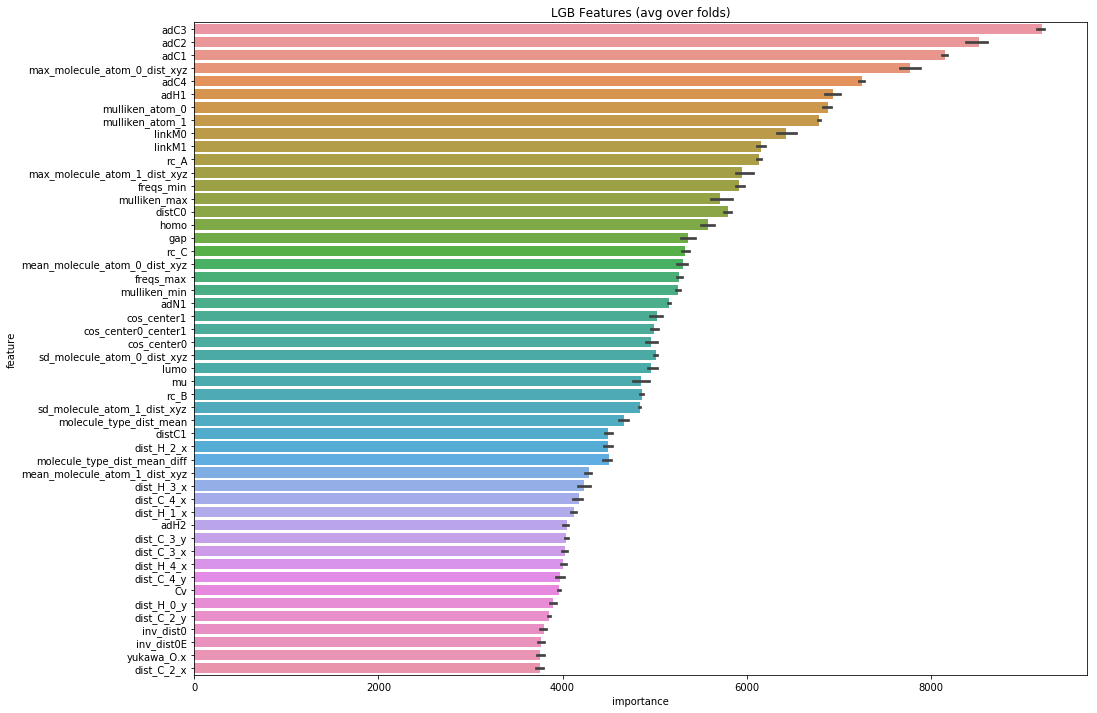

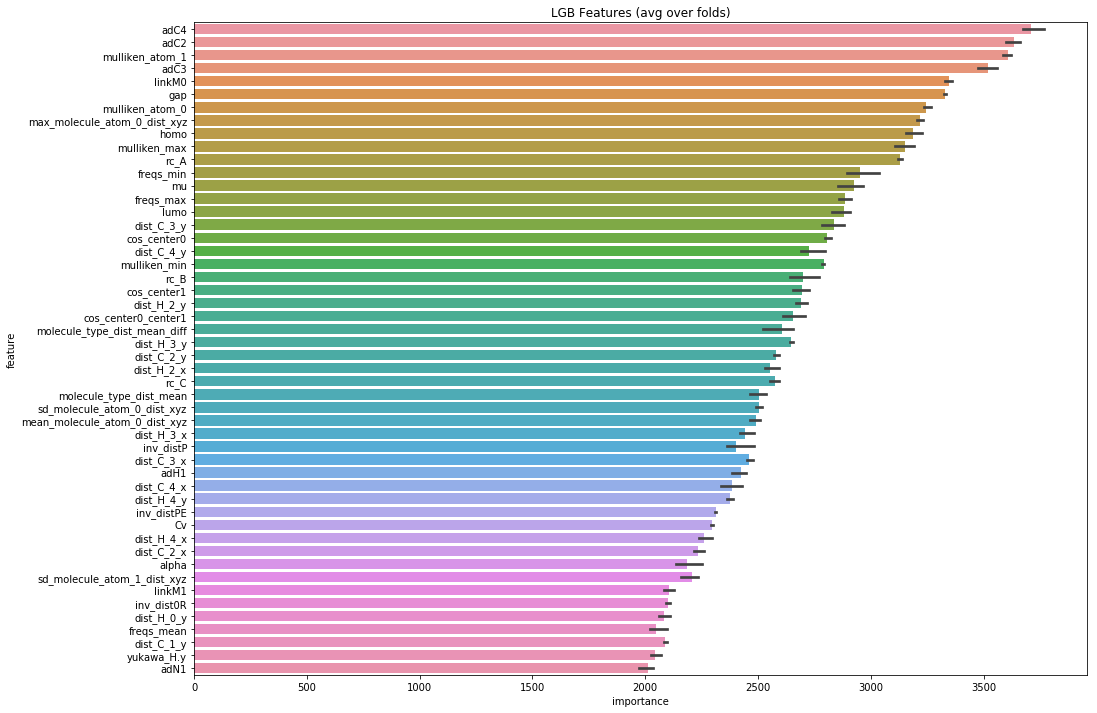

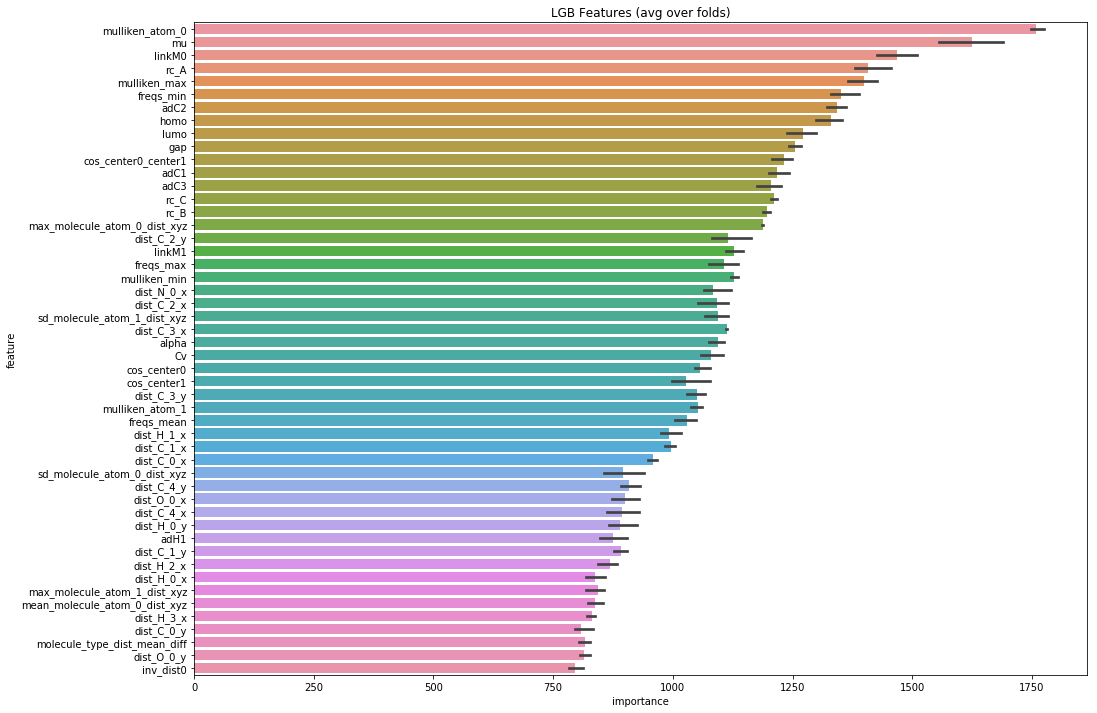

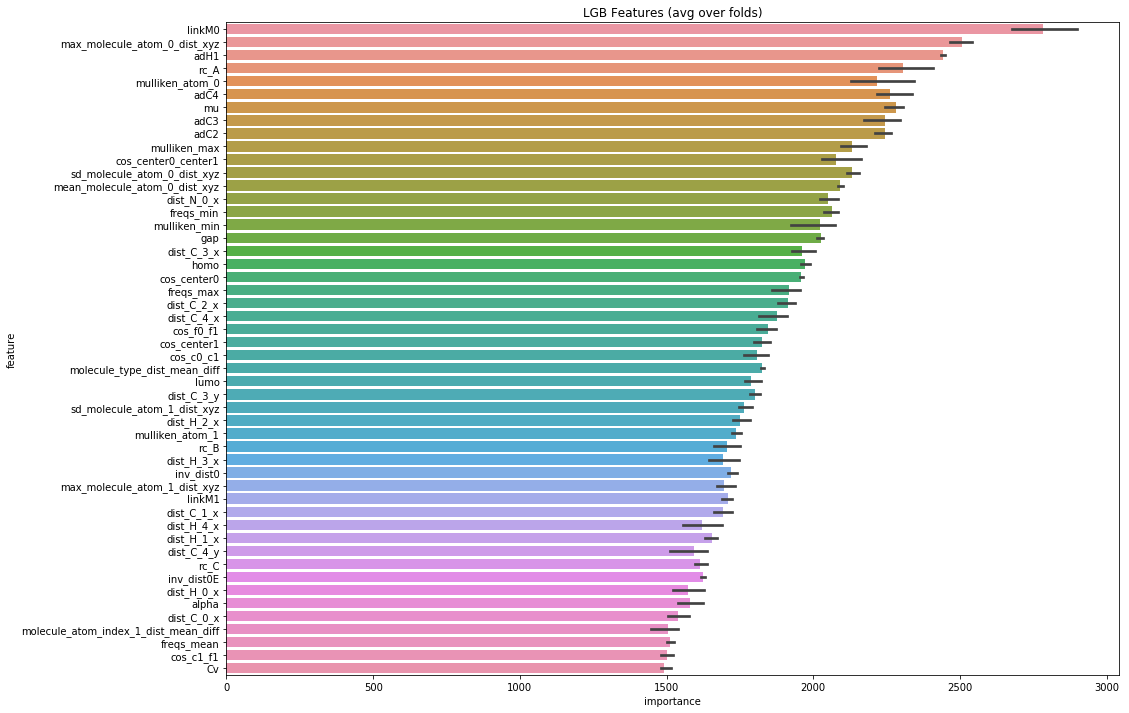

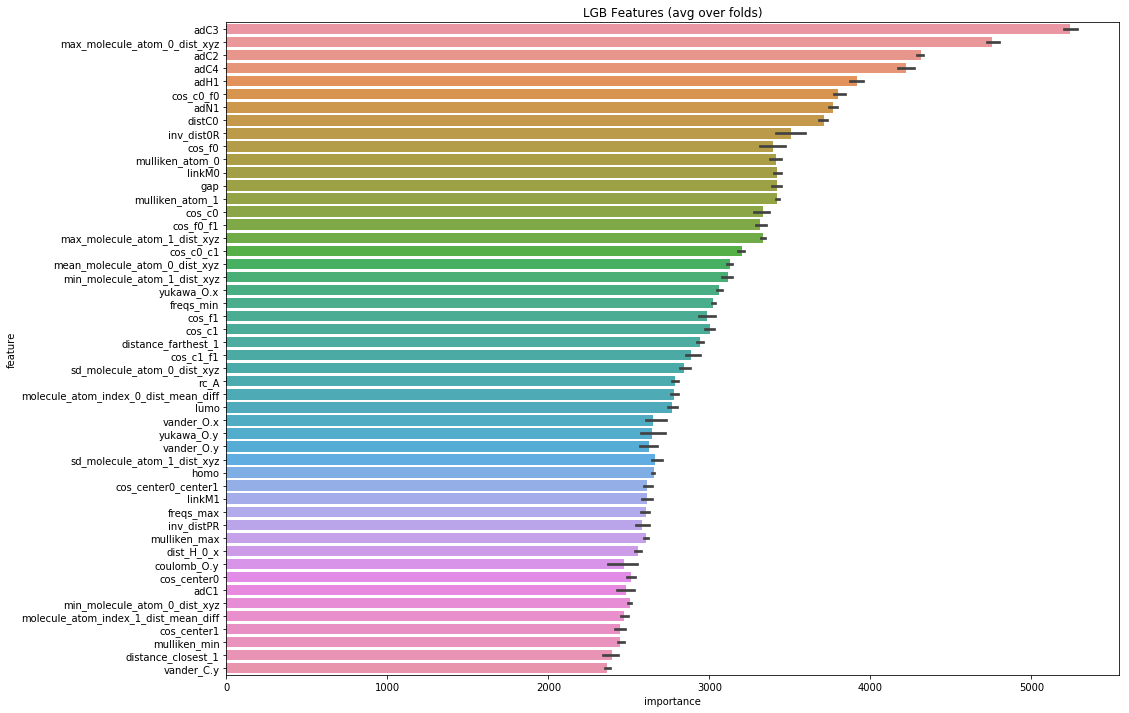

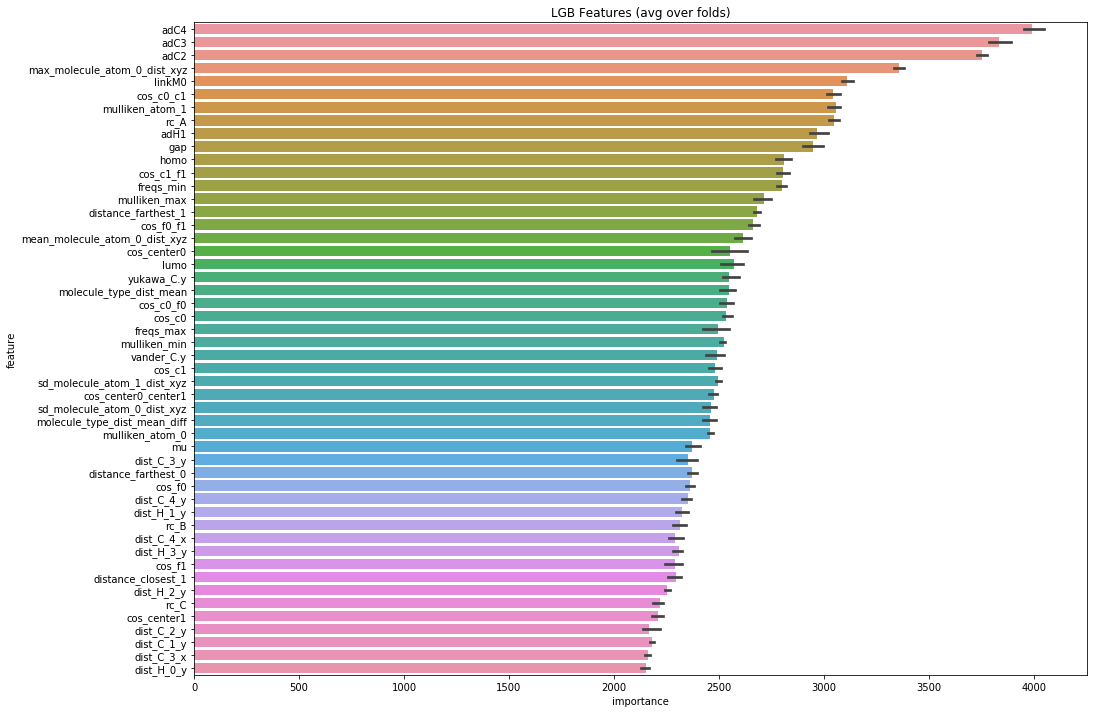

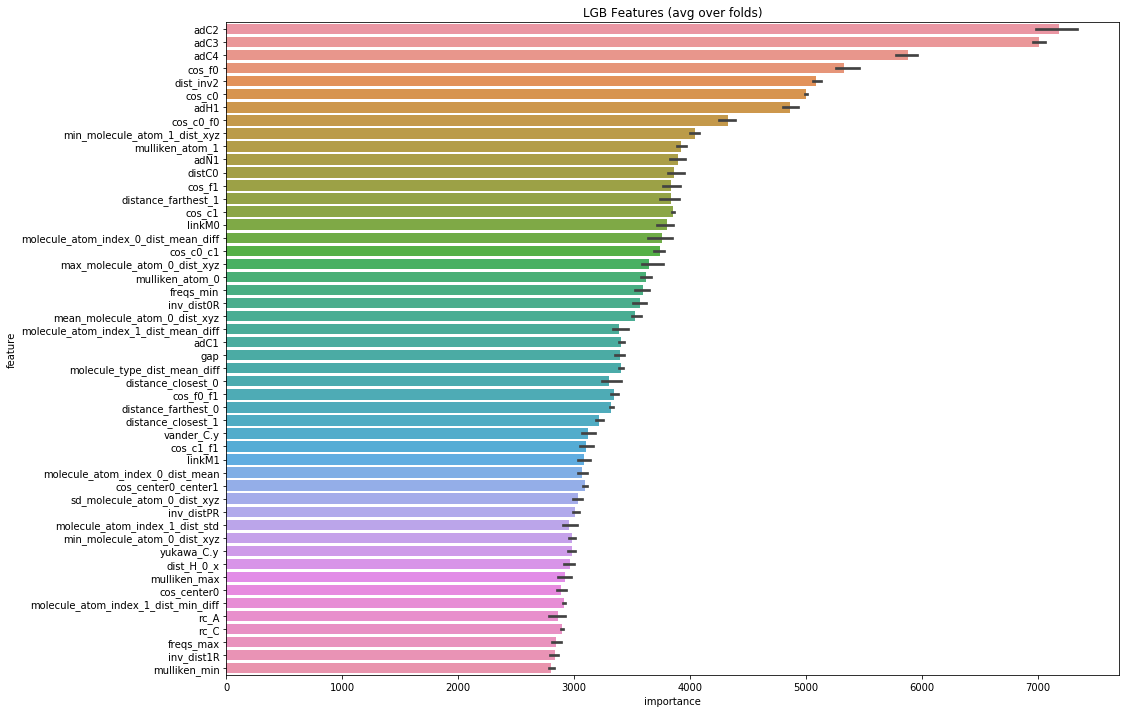

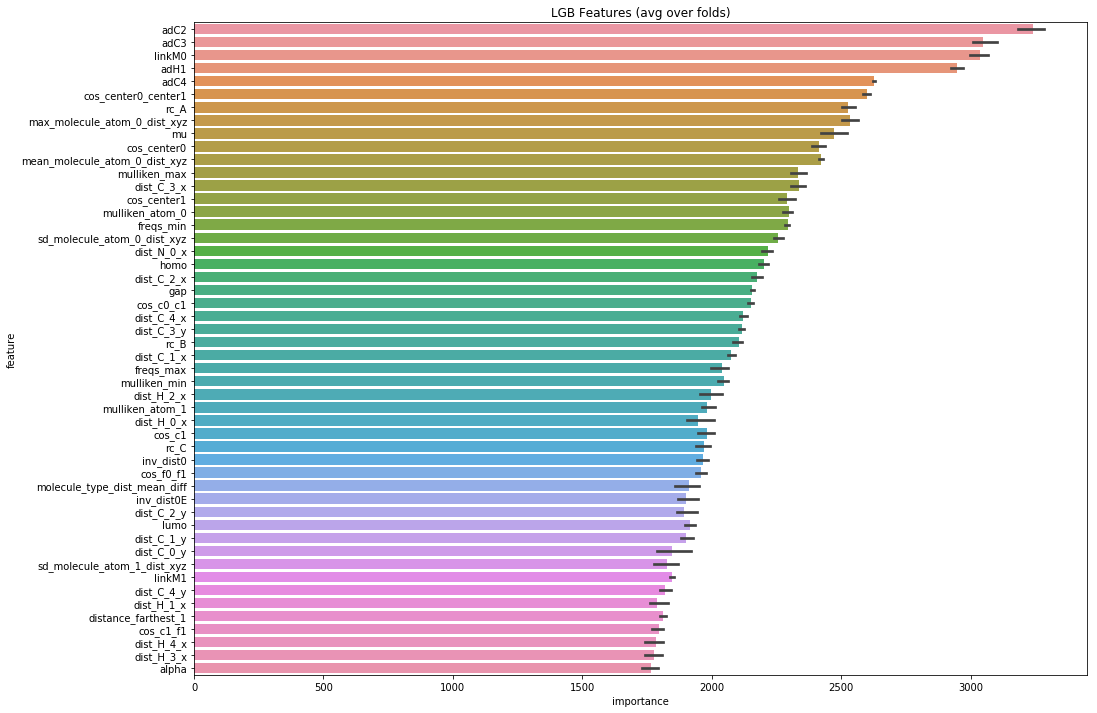

In [12]:
%%time
CV_score = 0
###Iters###    [1JHC, 1JHN, 2JHC, 2JHH, 2JHN, 3JHC, 3JHH, 3JHN]
n_estimators = [5000, 2500, 3000, 2500, 2500, 3000, 2500, 2500]


for t in train['type'].unique():
    # typeの最初の数字を取得
    type_ = lbl.inverse_transform([t])[0]
    print(f'\nTraining of type {t}: {type_}.')
    # 注目typeのindex取得
    index_type = (train['type'] == t)
    index_type_test = (test['type'] == t)
    
    X_t = train.loc[index_type].copy()
    X_test_t = test.loc[index_type_test].copy()
    y_t = y[index_type]
    
    print(f'Generating features...')
    start_time = time.time()
    
    ## Generating features from the public kernels, just by type
    ## no memory reduction is needed
    X_t = get_features(X_t, structures.copy())
    X_t = X_t[good_columns].fillna(0.0)
    
    X_test_t = get_features(X_test_t, structures.copy())
    X_test_t = X_test_t[good_columns].fillna(0.0)
    
    ## load Giba's features just for type t by getting rows to be excluded when initiating read_csv
    rows_to_exclude = np.where(index_type==False)[0]+1 # retain the header row
    rows_to_exclude_test = np.where(index_type_test==False)[0]+1
    train_giba_t = pd.read_csv('giba-molecular-features/train_giba.csv',
                        header=0, skiprows=rows_to_exclude, usecols=giba_columns)
    test_giba_t = pd.read_csv('giba-molecular-features/test_giba.csv',
                       header=0, skiprows=rows_to_exclude_test, usecols=giba_columns)
    
    X_t = pd.concat((X_t, train_giba_t), axis=1)

    X_test_t = pd.concat((X_test_t,test_giba_t), axis=1) 
    
    del train_giba_t, test_giba_t
    gc.collect()
    
    print(f'Done in {(time.time() - start_time):.2f} seconds for {X_t.shape[1]} features.')
    ## feature generation done
    
    
    result_dict_lgb = train_model_regression(X=X_t, X_test=X_test_t, 
                                              y=y_t, params=params, 
                                              folds=folds, 
                                              model_type='lgb', 
                                              eval_metric='mae', 
                                              plot_feature_importance=True,
                                              verbose=2000, early_stopping_rounds=200, 
                                              n_estimators=n_estimators[t])
    del X_t, X_test_t
    gc.collect()
    
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict_lgb['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict_lgb['prediction']
    
    ## manually computing the cv score
    CV_score += np.log(np.array(result_dict_lgb['scores']).mean())/8 # total 8 types

In [20]:
sub['scalar_coupling_constant'] = X_short_test['prediction']
today = str(datetime.date.today())
sub.to_csv(f'LGB_{today}_{CV_score:.4f}.csv', index=False)